In [ ]:
!pip install numpy matplotlib jax scipy scikit-optimize ucimlrepo optax

# Binary logistic regression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

Array([  0, 228], dtype=uint32)

In [1]:
@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, y_train, X_test, y_test

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, 0, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy



# @jit
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
    }
    return metrics

def gradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)
    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        if learning_rate == "linesearch":
            # Simple line search implementation
            phi = lambda alpha: f(w - alpha*grad_val)
            result = minimize_scalar(fun=phi, 
                                     bounds=(1e-3, 2e2)
                              )
            step_size = result.x
        else:
            step_size = learning_rate
        w -= step_size * grad_val
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

def run_experiments(params):
    mu = params["mu"]
    m, n = params["m"], params["n"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem(m, n, mu)
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features
    
    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    x_star, f_star = compute_optimal(X_train, y_train, mu)

    for method in methods:
        learning_rate = method["learning_rate"]
        iterations = method["iterations"]
        trajectory, times = gradient_descent(x_0, X_train, y_train, learning_rate, iterations, mu)
        label = method["method"] + " " + str(learning_rate)
        results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    mu = params["mu"]
    
    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. mu={mu}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

<>:133: SyntaxWarning: invalid escape sequence '\|'
<>:165: SyntaxWarning: invalid escape sequence '\|'
<>:133: SyntaxWarning: invalid escape sequence '\|'
<>:165: SyntaxWarning: invalid escape sequence '\|'
/var/folders/6l/qhfv4nh50cqfd22s2mp1shlm0000gn/T/ipykernel_87087/2871042674.py:133: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|x_k - x^*\|$')
/var/folders/6l/qhfv4nh50cqfd22s2mp1shlm0000gn/T/ipykernel_87087/2871042674.py:165: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|x_k - x^*\|$')


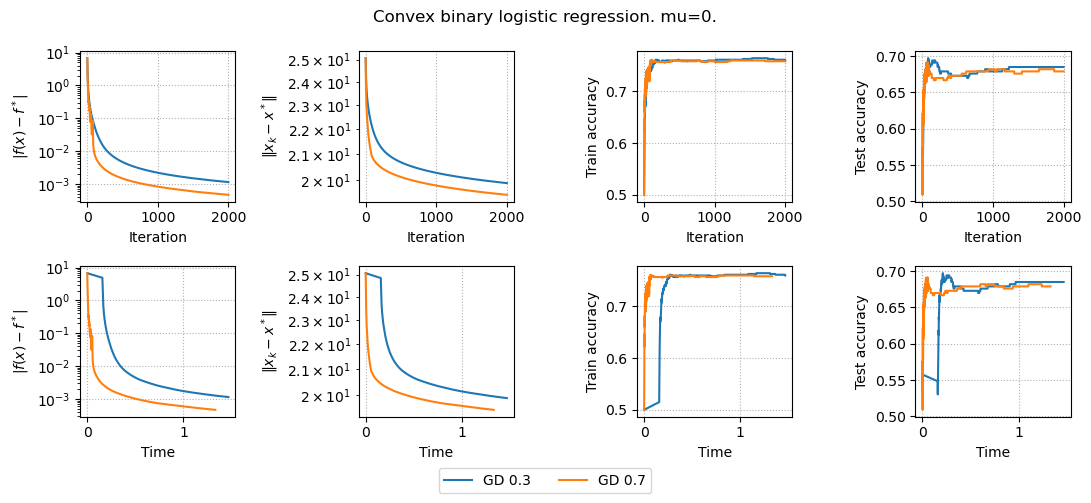

In [2]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

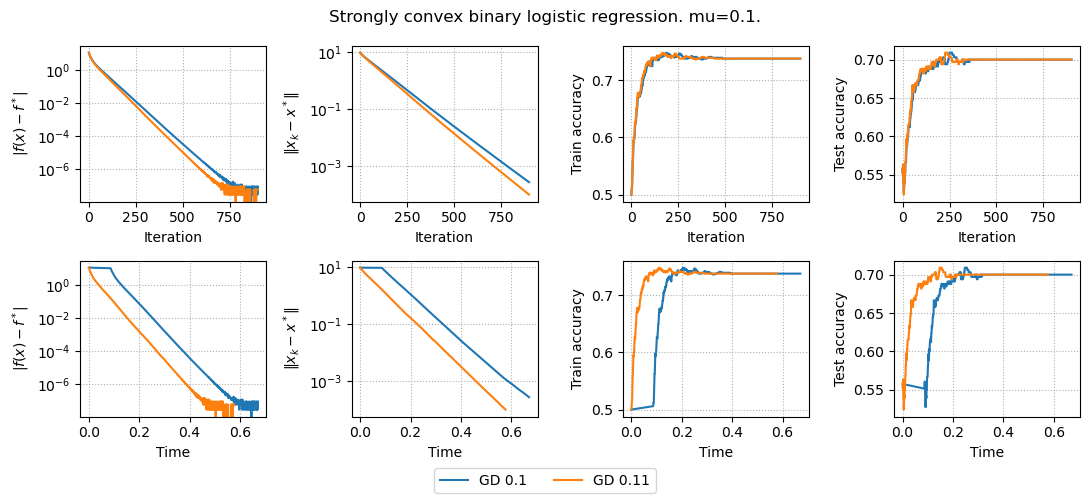

In [ ]:
params = {
    "mu": 1e-1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 1e-1,
            "iterations": 900,
        },
        {
            "method": "GD",
            "learning_rate": 1.1e-1,
            "iterations": 900,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

# Support Vector Machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

Array([  0, 228], dtype=uint32)

In [19]:
# Set a random seed for reproducibility
np.random.seed(228)
jax.random.PRNGKey(228)

# Generate a synthetic binary classification dataset
def generate_svm_data(m=1000, n=300):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, 
                                       n_informative=n//2, random_state=42)
    y = 2 * y - 1  # Convert labels to {-1, 1}
    return X, y

# Solve SVM using convex optimization
def compute_svm_optimal(X, y, C=1.0):
    m, n = X.shape
    w = cp.Variable(n)
    b = cp.Variable()
    slack = cp.Variable(m)

    # SVM objective: minimize 1/2 ||w||^2 + C * sum(slack)
    objective = cp.Minimize(0.5 * cp.norm(w, 2)**2 + C * cp.sum(slack))

    # Constraints:  y_i (x_i^T w + b) >= 1 - slack_i,  slack_i >= 0
    constraints = [
        cp.multiply(y, X @ w + b) >= 1 - slack,
        slack >= 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value, b.value, problem.value

# Hinge loss function
@jax.jit
def hinge_loss(w, b, X, y, C=1.0):
    margins = y * (X @ w + b)
    loss = jnp.maximum(0, 1 - margins)
    return 0.5 * jnp.sum(w**2) + C * jnp.mean(loss)

# Compute accuracy
@jax.jit
def compute_accuracy(w, b, X, y):
    preds = jnp.sign(X @ w + b)
    return jnp.mean(preds == y)

# Perform gradient descent for SVM optimization
def gradient_descent_svm(w_0, b_0, X, y, learning_rate=0.01, num_iters=100, C=1.0):
    trajectory = [w_0]
    times = [0]
    w, b = w_0, b_0
    f = lambda w, b: hinge_loss(w, b, X, y, C)
    
    iter_start = time.time()
    for i in range(num_iters):
        grad_w, grad_b = grad(f, argnums=(0, 1))(w, b)
        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    
    return trajectory, times

# Run SVM Experiments
def run_experiments_svm(params):
    C = params["C"]
    m, n = params["m"], params["n"]
    methods = params["methods"]
    results = {}

    X, y = generate_svm_data(m, n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    w_0 = jax.random.normal(jax.random.PRNGKey(0), (n,))
    b_0 = 0.0

    w_star, b_star, f_star = compute_svm_optimal(X_train, y_train, C)

    for method in methods:
        learning_rate = method["learning_rate"]
        iterations = method["iterations"]
        trajectory, times = gradient_descent_svm(w_0, b_0, X_train, y_train, learning_rate, iterations, C)
        label = method["method"] + " " + str(learning_rate)
        results[label] = {
            "f_gap": [jnp.abs(hinge_loss(w, b_0, X_train, y_train, C) - f_star) for w in trajectory],
            "x_gap": [jnp.linalg.norm(w - w_star) for w in trajectory],
            "time": times,
            "train_acc": [compute_accuracy(w, b_0, X_train, y_train) for w in trajectory],
            "test_acc": [compute_accuracy(w, b_0, X_test, y_test) for w in trajectory],
        }

    return results, params

# Plot Results
def plot_results_svm(results, params):
    plt.figure(figsize=(11, 5))
    C = params["C"]
    
    plt.suptitle(f"SVM Training Results. C={C}")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    plt.grid(linestyle=":")

    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

<>:119: SyntaxWarning: invalid escape sequence '\|'
<>:149: SyntaxWarning: invalid escape sequence '\|'
<>:119: SyntaxWarning: invalid escape sequence '\|'
<>:149: SyntaxWarning: invalid escape sequence '\|'
/var/folders/6l/qhfv4nh50cqfd22s2mp1shlm0000gn/T/ipykernel_86548/3657982053.py:119: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|x_k - x^*\|$')
/var/folders/6l/qhfv4nh50cqfd22s2mp1shlm0000gn/T/ipykernel_86548/3657982053.py:149: SyntaxWarning: invalid escape sequence '\|'
  plt.ylabel('$\|x_k - x^*\|$')


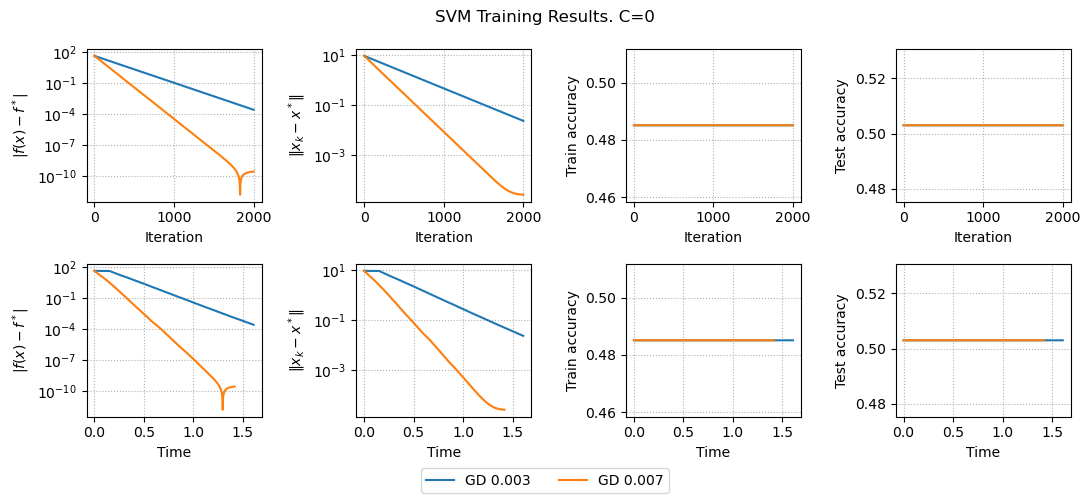

In [20]:
params = {
    "C": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-3,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-3,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments_svm(params)
plot_results_svm(results, params)

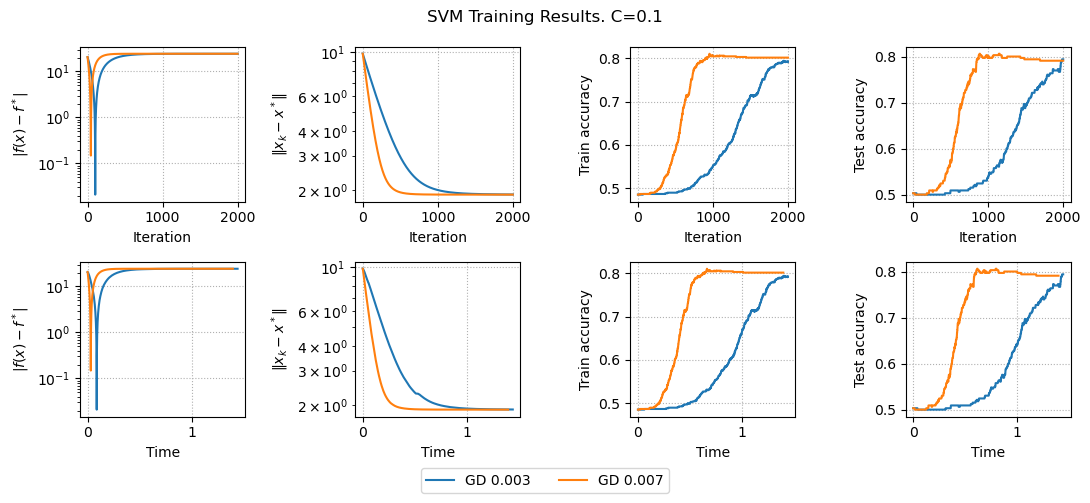

In [10]:
params = {
    "C": 0.1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-3,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-3,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments_svm(params)
plot_results_svm(results, params)